In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Whirly"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn088511,MSLGPRESCEFFHDPFKGKSEEGKVRKVLKVEPLPDGTGHFFNLSW...,276,1
1,Achn144601,MRERDAWVSLGGGEIESSFEEEDIGEGLGIQNPNRWSIIHSPSSLN...,341,1
2,Achn183721,MLNLFLSSSPPGLTIPNPKPFCVLHSFSSLDAIAAIRLKPTPSSLS...,649,1
3,EMT14910,MGFSIDGPGRGLGFLPRALLGPAYGQSGAYKVAKEGFVLLQFAPAV...,219,1
4,EMT15491,MLRLSRFLPSTSRGVTDLKDVLWSGSLTFKHALSTSAANVDARYML...,352,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
492,0.008197,0.000000,0.000000,0.008197,0.000000,0.000000,0.0000,0.000000,0.0,0.024590,...,0.00000,0.0000,0.0,0.000000,0.000000,0.008197,0.000000,0.0,0.0,0.00000
498,0.009646,0.003215,0.000000,0.006431,0.006431,0.000000,0.0000,0.003215,0.0,0.003215,...,0.00000,0.0000,0.0,0.000000,0.003215,0.000000,0.003215,0.0,0.0,0.00000
360,0.031646,0.003165,0.003165,0.006329,0.003165,0.006329,0.0000,0.000000,0.0,0.022152,...,0.00000,0.0000,0.0,0.000000,0.003165,0.003165,0.000000,0.0,0.0,0.00000
915,0.005900,0.000000,0.000000,0.008850,0.000000,0.000000,0.0059,0.002950,0.0,0.014749,...,0.00295,0.0059,0.0,0.000000,0.002950,0.000000,0.002950,0.0,0.0,0.00295
704,0.006711,0.006711,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.006711,...,0.00000,0.0000,0.0,0.006711,0.000000,0.000000,0.000000,0.0,0.0,0.00000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (833, 437)
X_test: (209, 437)
y_train: (833,)
y_test: (209,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,393 (607.00 KB)

 Trainable params: 155,393 (607.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.5781 - loss: 0.6930

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5395 - loss: 0.6908 - val_accuracy: 0.9401 - val_loss: 0.6716


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8750 - loss: 0.6756

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9206 - loss: 0.6591 - val_accuracy: 0.9701 - val_loss: 0.5712


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.5766

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9695 - loss: 0.5334 - val_accuracy: 0.9820 - val_loss: 0.3537


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.3480

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - loss: 0.2893 - val_accuracy: 0.9760 - val_loss: 0.1212


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1348

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9876 - loss: 0.1031 - val_accuracy: 0.9701 - val_loss: 0.0662


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0285

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9924 - loss: 0.0341 - val_accuracy: 0.9820 - val_loss: 0.0621


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0397

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9948 - loss: 0.0315 - val_accuracy: 0.9760 - val_loss: 0.0539


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0063

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.9760 - val_loss: 0.0665


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0015

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - loss: 0.0148 - val_accuracy: 0.9760 - val_loss: 0.0517


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0073

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.9760 - val_loss: 0.0539


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0067

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9760 - val_loss: 0.0584


Epoch 12/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0057

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0163 - val_accuracy: 0.9760 - val_loss: 0.1006


Epoch 13/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0565

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0182 - val_accuracy: 0.9760 - val_loss: 0.0633



[Train Accuracy: 99.55% - Test Accuracy: 99.04%]


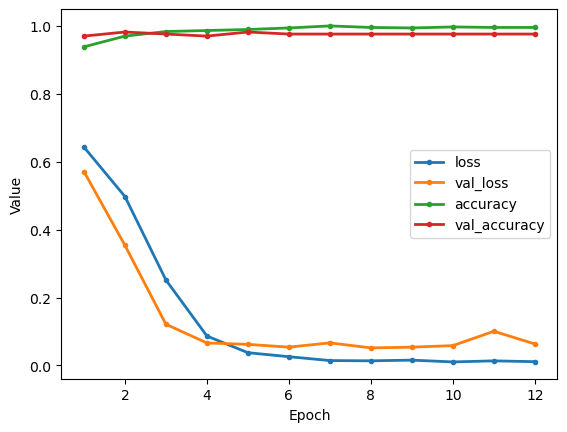

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYX,YYY
492,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.004115,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.000000,0.000000,0.000000,0.003226,0.0,0.000000,0.000000,0.0,0.0,0.003226,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.012698,0.003175,0.003175,0.000000,0.0,0.003175,0.000000,0.0,0.0,0.003175,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002959,0.0,0.0,0.002959,...,0.002959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (833, 8231)
X_test: (209, 8231)
y_train: (833,)
y_test: (209,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,107,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,150,657 (8.20 MB)

 Trainable params: 2,150,657 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.6250 - loss: 0.6931

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5409 - loss: 0.6921  

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5298 - loss: 0.6908 - val_accuracy: 0.5090 - val_loss: 0.6705


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.6745

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5702 - loss: 0.6578 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5993 - loss: 0.6500 - val_accuracy: 0.9162 - val_loss: 0.5670


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9375 - loss: 0.5503

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9304 - loss: 0.5187 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9364 - loss: 0.5042 - val_accuracy: 1.0000 - val_loss: 0.3576


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.3507

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.3032 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9984 - loss: 0.2927 - val_accuracy: 0.9940 - val_loss: 0.1872


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.1764

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.1380 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9962 - loss: 0.1301 - val_accuracy: 0.9760 - val_loss: 0.0721


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0496

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.0341 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0316 - val_accuracy: 0.9820 - val_loss: 0.0459


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0084

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0079 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9997 - loss: 0.0087 - val_accuracy: 0.9820 - val_loss: 0.0357


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0011

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0074 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9983 - loss: 0.0078 - val_accuracy: 0.9760 - val_loss: 0.0786


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0030

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.0046 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0043 - val_accuracy: 0.9820 - val_loss: 0.0562


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0015

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9820 - val_loss: 0.0502


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 9.1184e-04

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012     

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9820 - val_loss: 0.0563


Epoch 12/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0015

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9820 - val_loss: 0.0776


Epoch 13/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.9452e-04

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8103e-04 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2254e-04 - val_accuracy: 0.9820 - val_loss: 0.0758



[Train Accuracy: 100.00% - Test Accuracy: 98.09%]


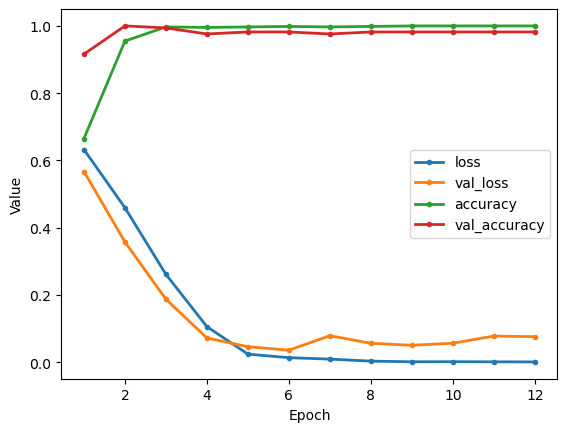

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYG,YYYH,YYYL,YYYN,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
492,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.006369,0.0,0.0,0.0,0.0,0.003185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
915,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      23,123,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,164,417 (88.37 MB)

 Trainable params: 23,164,417 (88.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 7s 776ms/step - accuracy: 0.5625 - loss: 0.6931

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5703 - loss: 0.6931 

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5642 - loss: 0.6930

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5765 - loss: 0.6929

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5912 - loss: 0.6928

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6081 - loss: 0.6926

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6249 - loss: 0.6923

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6386 - loss: 0.6921

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6498 - loss: 0.6918

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6590 - loss: 0.6915

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.6733 - loss: 0.6909 - val_accuracy: 0.9701 - val_loss: 0.6710


Epoch 2/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9688 - loss: 0.6704

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9648 - loss: 0.6697 

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9679 - loss: 0.6683

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9691 - loss: 0.6670

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9709 - loss: 0.6656

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9727 - loss: 0.6641

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9740 - loss: 0.6627

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9753 - loss: 0.6611

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9765 - loss: 0.6593

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9776 - loss: 0.6574

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9794 - loss: 0.6542 - val_accuracy: 1.0000 - val_loss: 0.5766


Epoch 3/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9844 - loss: 0.5676

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9844 - loss: 0.5672

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9861 - loss: 0.5630

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9876 - loss: 0.5592

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9889 - loss: 0.5544

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9894 - loss: 0.5495

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9900 - loss: 0.5444

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9905 - loss: 0.5392

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9910 - loss: 0.5343

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9914 - loss: 0.5294

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9921 - loss: 0.5214 - val_accuracy: 0.9940 - val_loss: 0.3591


Epoch 4/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.3292

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.3202

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.3164

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.3145

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.3099

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.3049

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.2998

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.2947

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9998 - loss: 0.2896

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9997 - loss: 0.2846

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9992 - loss: 0.2766 - val_accuracy: 0.9701 - val_loss: 0.1413


Epoch 5/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.1065

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.1004 

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0953

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0934

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0916

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0898

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0881

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0863

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0845

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9998 - loss: 0.0827

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9996 - loss: 0.0797 - val_accuracy: 0.9760 - val_loss: 0.0548


Epoch 6/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9844 - loss: 0.0634

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9844 - loss: 0.0543

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9861 - loss: 0.0480

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9876 - loss: 0.0436

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9889 - loss: 0.0404

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9898 - loss: 0.0378

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9907 - loss: 0.0358

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9913 - loss: 0.0340

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9919 - loss: 0.0325

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9924 - loss: 0.0311

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9932 - loss: 0.0291 - val_accuracy: 0.9880 - val_loss: 0.0336


Epoch 7/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0064

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0062

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0062

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0060

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0060

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0058

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0058

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0057

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0056

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0056

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9760 - val_loss: 0.0347


Epoch 8/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0026

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0025

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0025

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0024

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0024

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0023

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0023

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0023

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0023

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0024

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9760 - val_loss: 0.0345


Epoch 9/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0012

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0012

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0014

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0014

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0014

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9880 - val_loss: 0.0271


Epoch 10/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0010

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 9.0426e-04

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.0031e-04

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 9.2431e-04

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 9.5688e-04

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 9.8073e-04

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 9.9254e-04

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.9832e-04

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.9666e-04

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0010    

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9820 - val_loss: 0.0297


Epoch 11/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0029

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0024

 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0021

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0019

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0018

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0017

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0017

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0016

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0016

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0015

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9820 - val_loss: 0.0298


Epoch 12/100


 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.0010

 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 9.8648e-04

 3/11 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 9.5544e-04

 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 9.4561e-04

 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 9.3754e-04

 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 9.1926e-04

 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 8.9882e-04 

 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 8.8142e-04

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 8.6688e-04

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 8.5379e-04

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 8.3425e-04 - val_accuracy: 0.9760 - val_loss: 0.0382



[Train Accuracy: 100.00% - Test Accuracy: 97.13%]


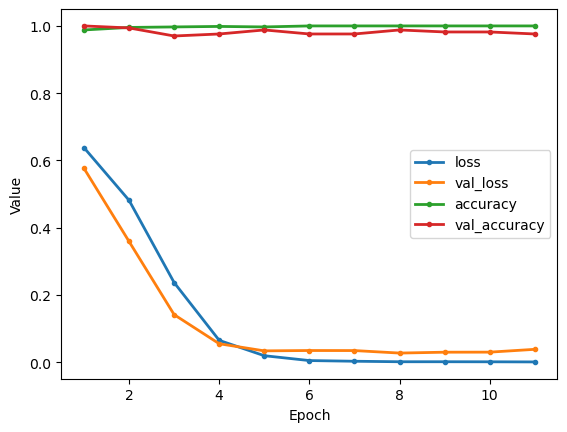

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [26]:
report.save()

Report saved as Output/Reports/Whirly/report_2T8EKEQ4.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################